# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn import preprocessing
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
azdias.head(20)

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
# check how the summary file is structured
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
feat_info['missing_or_unknown'].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[XX]         1
[-1,XX]      1
[-1,X]       1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [92]:
# Identify missing or unknown data values and convert them to NaNs.

# Meaning of the error codes is explained in Data_Dictionary.md. 
# For the following steps, replace every occurrence of every error code in the data with NaN.

# Temporarily replace NaNs already present in the data with arbitrary number.
# Otherwise would prevent downcasting numbers to intgers which is needed for comparison with feat_info
azdias.fillna(value=9999, inplace=True)
for column in azdias:
    azdias[column] = pd.to_numeric(azdias[column], downcast='integer', errors='ignore')

error_list=feat_info['missing_or_unknown'].str.strip('[]')
error_list2=error_list.str.split(',')

for i in list(range(error_list2.size)):
    findthis = error_list2[i]
    onecolumn = azdias.iloc[:,i].astype(np.str)
    onecolumn.replace(findthis, value=np.nan, inplace=True)
    onecolumn.replace(np.str(9999), value=np.nan, inplace=True)
    azdias[azdias.columns[i]] = onecolumn
    
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2,1,2,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,5,1,5,2,5,4,5,...,2,3,2,1,1,5,4,3,5,4
2,NaN,3,2,3,1,4,1,2,3,5,...,3,3,1,0,1,4,4,3,5,2
3,2,4,2,2,4,2,5,2,1,2,...,2,2,2,0,1,3,4,2,3,3
4,NaN,3,1,5,4,3,4,1,3,2,...,2,4,2,1,2,3,3,4,6,5


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

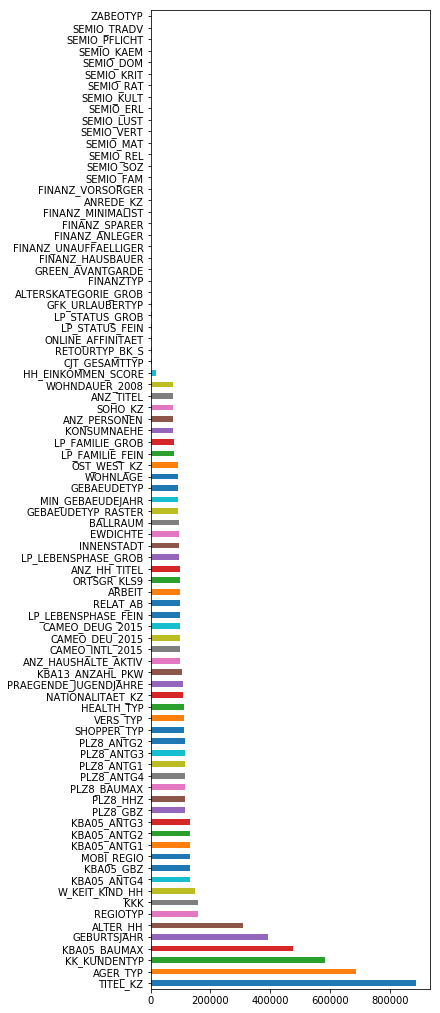

In [93]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# df_nan = azdias.iloc[azdias.isnull().sum(1).sort_values(ascending=False).index]

df_nan = azdias.isnull().sum().sort_values(ascending=False)

df_nan.plot(kind='barh', figsize=(5,18))

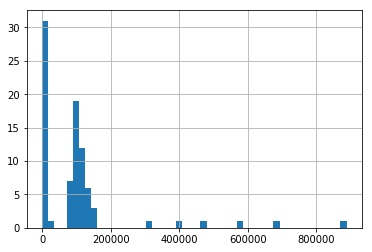

In [94]:
# Investigate patterns in the amount of missing data in each column.

# azdias.isnull().sum().hist(bins=50)

df_nan.hist(bins=50)

In [96]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columnns_to_drop = ['TITEL_KZ',
                    'AGER_TYP',
                    'KK_KUNDENTYP',
                    'KBA05_BAUMAX',
                    'GEBURTSJAHR',
                    'ALTER_HH']

azdias.drop(columnns_to_drop, axis=1, inplace=True)

# I realized later that I also need the cleaned version of feat_info:
feat_info = feat_info[feat_info['attribute'].isin(columnns_to_drop) == False]

#### Discussion 1.1.2: Assess Missing Data in Each Column

The histogram reveals a cluster of columns in the area of 100'000 missing values. One could argue to remove those columns. However, since they make up around half of all features, I would not call those columns outliers. Thus, I manually remove only the very obvious outlier columns where more than 200'000 data points are missing, namely 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR' and 'ALTER_HH'.

Some of these dropped columns contain features that either only apply to a small subset of people (e.g. AGER_TYP applies only to elderly people and describes their preferred activities), are lacking a value that would encode for the majority of people (e.g. TITEL_KZ only contains options such as Dr. Prof. or unknown, but no option for "no title" which are then all encoded as NaN), or may simply be difficult to obtain (such as description of the building type in the microcell for KBA05_BAUMAX).



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [97]:
# How much data is missing in each row of the dataset?

df_nan_rows = azdias.isnull().sum(axis=1).sort_values(ascending=False)

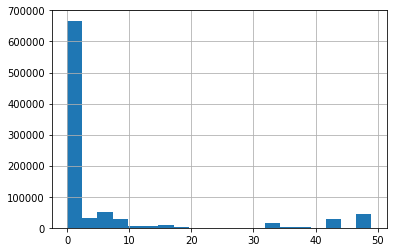

In [98]:
# df_nan_rows.plot(kind='barh', figsize=(5,18))
df_nan_rows.hist(bins=20)

In [100]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

data_fewNaN = azdias[azdias.isnull().sum(axis=1)<10]
data_manyNaN = azdias[azdias.isnull().sum(axis=1)>=10]

There were no apparent clusters, so I chose an arbitrary intermediate value that excluded some rows but kept most of the data.

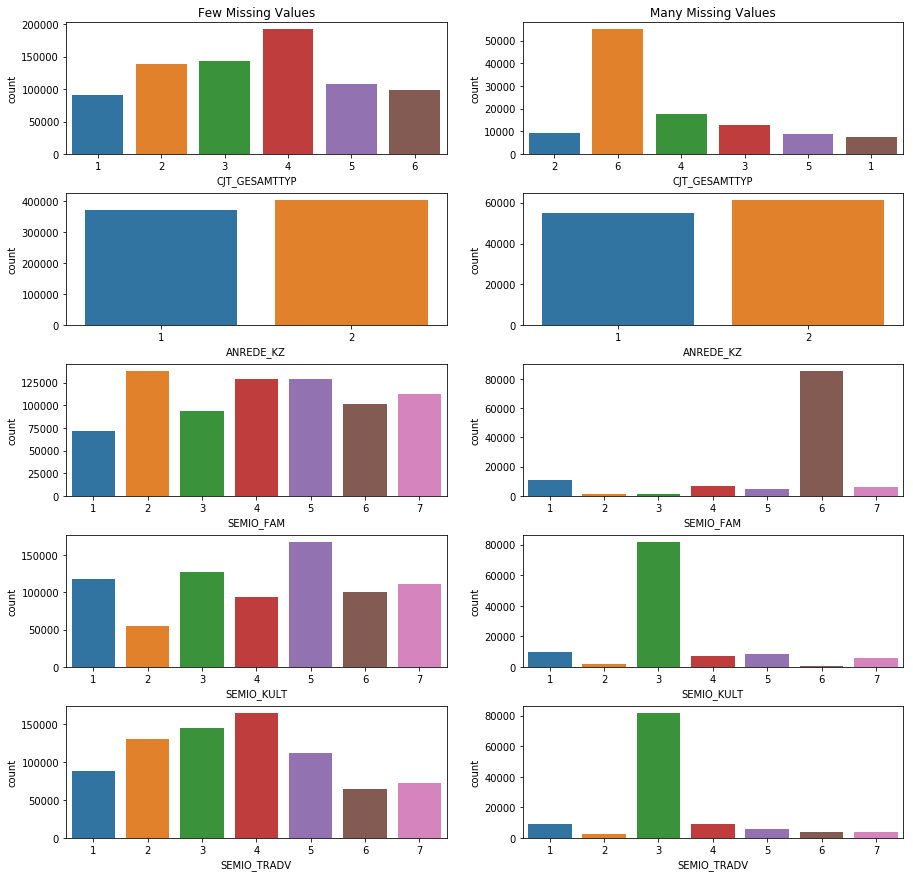

In [101]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

n_comparisons = 5

fig, axes = plt.subplots(n_comparisons,2,figsize=(15,15))
plt.subplots_adjust(hspace=0.3)
    
axes[0,0].set_title('Few Missing Values')
axes[0,1].set_title('Many Missing Values')

for k in np.arange(0,n_comparisons):
    i = random.randint(0,data_fewNaN.shape[1])
    sns.countplot(x=data_fewNaN.iloc[:,i], ax=axes[k,0])
    sns.countplot(x=data_manyNaN.iloc[:,i], ax=axes[k,1])



#### Discussion 1.1.3: Assess Missing Data in Each Row


For some features there are quite substantial differences in the distribution of the values between the data with few and many missing values (Examples: ANREDE_KZ, SEMIO_FAM, SEMIO_KULT, and many more). 
After comparing several random columns I conclude that it would be better to keep even those rows that contain many missing values, as their removal significantly affects the remaining data columns.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

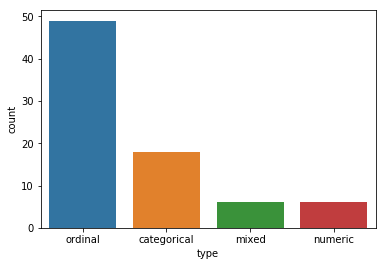

In [103]:
# How many features are there of each data type?

sns.countplot(x=feat_info['type'])

feat_info['type'].value_counts()

If we look in feat_info we see that there are four different types of features in the remaining data set. The majority of features is ordinal, followed by categorical, while mixed and numeric  types contain less than ten features each.  

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [104]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# First, we need to filter out the categorical columns. 
# For this I use the third column of feat_info as indexer
indexer = feat_info['type'] == 'categorical'
indexer = indexer.values
categoricals = azdias.loc[:, indexer]

# we can make use of pandas category datatype:
for column in categoricals:
    azdias[column]=categoricals[column].astype('category')
    
azdias.loc[:, indexer].describe()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
count,891221,886367,891221,886367,891221,813429,813429,886367,886367,782906,780025,817722,780025,891221,798073,798073,791869,791869
unique,2,6,6,12,2,11,5,10,5,3,4,2,2,6,7,2,9,44
top,2,4,6,12,0,1,1,1,1,1,1,0,2,3,1,W,8,6B
freq,465305,210963,290367,138545,715996,426379,426379,219275,337511,684085,254761,810834,398722,364905,460465,629528,134441,56672


Now describe() gives us a summary of the categoric features, including the unique values.

Looking at the values below, we also see that 'OST_WEST_KZ' has non-numeric values that need to be changed later.

In [105]:
azdias.loc[:, indexer].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1,2,4,10,0,2,2,1,1,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
1,2,5,1,10,0,5,3,2,1,1,3,1,2,5,8,W,8,8A
2,2,3,1,10,1,1,1,3,2,1,2,0,1,5,1,W,4,4C
3,2,2,6,1,0,NaN,NaN,9,4,1,1,0,1,3,1,W,2,2A
4,1,5,5,5,0,10,5,3,2,1,2,0,2,4,1,W,6,6B


In [106]:
# Dropping columns with too many (>5) categorical values

# I reuse the dataframe of categorical columns from before:
for column in categoricals:
    if categoricals[column].nunique() > 5:
        print(f'dropping {column}')
        azdias.drop(column, axis=1, inplace=True)
        categoricals.drop(column, axis=1, inplace=True)
    
azdias.head()    

dropping CJT_GESAMTTYP


C:\Users\felix\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


dropping FINANZTYP
dropping GFK_URLAUBERTYP
dropping LP_FAMILIE_FEIN
dropping LP_STATUS_FEIN
dropping ZABEOTYP
dropping GEBAEUDETYP
dropping CAMEO_DEUG_2015
dropping CAMEO_DEU_2015


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,1,3,4,3,5,5,3,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,1,5,2,5,4,5,0,3,...,2,3,2,1,1,5,4,3,5,4
2,3,2,1,4,1,2,3,5,1,3,...,3,3,1,0,1,4,4,3,5,2
3,4,2,4,2,5,2,1,2,0,2,...,2,2,2,0,1,3,4,2,3,3
4,3,1,4,3,4,1,3,2,0,3,...,2,4,2,1,2,3,3,4,6,5


In [107]:
categoricals.head()

,ANREDE_KZ,GREEN_AVANTGARDE,LP_FAMILIE_GROB,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,1,0,2,1,NaN,NaN,NaN,NaN,NaN
1,2,0,3,1,1,3,1,2,W
2,2,1,1,2,1,2,0,1,W
3,2,0,NaN,4,1,1,0,1,W
4,1,0,5,2,1,2,0,2,W


In [108]:
# Re-encode categorical variable(s) to be kept in the analysis.


dummy_columns = []
for column in categoricals:
    # special case of binary non-numeric column, and columns with more than two values
    if column == 'OST_WEST_KZ' or categoricals[column].nunique() > 2:
        print(column)
        # adding one hot encoded dataframes to a list, dropping the original column
        dummy_columns.append(pd.get_dummies(azdias[column], prefix=column))
        azdias.drop(column, axis=1, inplace=True)

# putting everything together
dummy_df = pd.concat(dummy_columns, axis=1)
data_categorical = pd.concat([azdias, dummy_df], axis=1)

data_categorical.head()

LP_FAMILIE_GROB
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
OST_WEST_KZ


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_STATUS_GROB_5,NATIONALITAET_KZ_1,NATIONALITAET_KZ_2,NATIONALITAET_KZ_3,SHOPPER_TYP_0,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,OST_WEST_KZ_O,OST_WEST_KZ_W
0,2,1,3,4,3,5,5,3,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,2,1,5,2,5,4,5,0,3,...,0,1,0,0,0,0,0,1,0,1
2,3,2,1,4,1,2,3,5,1,3,...,0,1,0,0,0,0,1,0,0,1
3,4,2,4,2,5,2,1,2,0,2,...,0,1,0,0,0,1,0,0,0,1
4,3,1,4,3,4,1,3,2,0,3,...,0,1,0,0,0,0,1,0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

There are several multi-level categoricals with up to 45 values. 
To keep the number of columns after one-hot-encoding low enough for reasonable computation time, I  droped all categorical columns with more than 5 values. In the end, 11 features were removed from the dataset and 4 features (LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, OST_WEST_KZ) were one-hot-encoded with get_dummies(). Based on their description in Data_Dictionary.md I think all the remaining features seem relevant. NaN values are now represented as a zero value in all dummy columns of a feature.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [109]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

data_categorical['PRAEGENDE_JUGENDJAHRE'].unique()

array([nan, '14', '15', '8', '3', '10', '11', '5', '9', '6', '4', '2',
       '1', '12', '13', '7'], dtype=object)

In [110]:
# based on the description in Data_Dictionary.md:

decades = {2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
data_categorical['PRAEGENDE_JUGENDJAHRE_decade']=data_categorical['PRAEGENDE_JUGENDJAHRE'].replace(decades)

movements = {3:1, 5:1, 8:1 ,10:1, 12:1, 14:1,  4:2, 6:2, 7:2, 9:2, 11:2, 13:2, 15:2}
data_categorical['PRAEGENDE_JUGENDJAHRE_movement']=data_categorical['PRAEGENDE_JUGENDJAHRE'].replace(movements)

del data_categorical['PRAEGENDE_JUGENDJAHRE']

In [111]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

data_categorical['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [112]:
def getDigit(x, n):
        return x // 10**n % 10  # https://stackoverflow.com/questions/39644638/how-to-take-the-nth-digit-of-a-number-in-python

wealth = data_categorical['CAMEO_INTL_2015'].astype(np.float).apply(getDigit, args=(1,))
life_stage = data_categorical['CAMEO_INTL_2015'].astype(np.float).apply(getDigit, args=(0,))

data_categorical['CAMEO_INTL_2015_wealth'] = wealth
data_categorical['CAMEO_INTL_2015_life_stage'] = life_stage
del data_categorical['CAMEO_INTL_2015']

check the remaining mixed features

In [113]:
# check which are still present in the dataset or have been removed in previous cleaning steps.
mixedfeaturelist = feat_info[feat_info['type'] == 'mixed']['attribute']

for feature in mixedfeaturelist:
    if feature in data_categorical.columns:
        print(f'{feature} is still present')
    else:
        print(f'{feature} has already been removed')

LP_LEBENSPHASE_FEIN is still present
LP_LEBENSPHASE_GROB is still present
PRAEGENDE_JUGENDJAHRE has already been removed
WOHNLAGE is still present
CAMEO_INTL_2015 has already been removed
PLZ8_BAUMAX is still present


In [56]:
data_categorical['PLZ8_BAUMAX'].unique()

array([nan, '1.0', '2.0', '4.0', '5.0', '3.0'], dtype=object)

In [115]:
# Engineering remaining features

# binary variable: 0 = family home,  1 = business
business = {1:0, 2:0, 3:0, 4:0, 5:1}
data_categorical['PLZ8_BAUMAX_business'] = data_categorical['PLZ8_BAUMAX'].replace(business)
nans = {5:np.nan}
data_categorical['PLZ8_BAUMAX'].replace(nans, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Two new features were created, 'PRAEGENDE_JUGENDJAHRE_decade' encodes the decade with the numbers 1-6, while 'PRAEGENDE_JUGENDJAHRE_movement' encodes "mainstream" as 0 and "avantgarde" as 1.

The last digit of 'CAMEO_INTL_2015' entered the new feature 'CAMEO_INTL_2015_life_stage', the second-last digit entered 'CAMEO_INTL_2015_wealth'. 

Since these new features encode the full information contained in 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015', I dropped the original features from the dataset.


*Comments about the remaining mixed features:*
- LP_LEBENSPHASE_FEIN/GROB : Both contain several dimensions of information, civil status, income, age and living situation. While each individual dimension is already present in separate features of the dataset, I decided to keep this features as they are. They may represent some nonlinear interactions between those dimension that might not be captured when just adding the features independently.

- WOHNLAGE: In principle this feature could be split into two dimensions: Neighborhood quality from 0-5, and a binary feature for rural/non-rural. Unfortunately the items flagged as rural don't have a neighborhood quality number, which would result in a lot of missing values in this feature. For simplicity I thus leave the original feature as it is.

- 'PLZ8_BAUMAX' required some engineering: I created the new binary feature 'PLZ8_BAUMAX_business' indicating whether the buildings are family homes or business buildings. I replace the business values in the original features with NaNs so that those features now purely encode the number of family homes.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

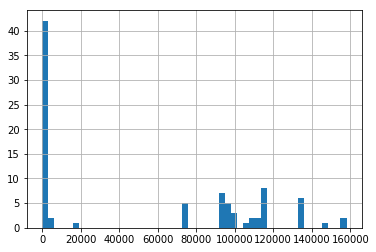

In [116]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Check whether my previous changes have not introduced columns with too many NaNs.
df_nan = data_categorical.isnull().sum().sort_values(ascending=False)
df_nan.hist(bins=50)

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# The dataframe already contains all the combined modified columns.

I realized I could have saved processing time If I had split the dataset into smaller subsets earlier. Instead I performed most processing steps in-place on the full data file. Thus I don't need this final combination step here.
However, to avoid running the same cleaning steps on the entire dataset over and over during the exercise, I used the pickle functions below to store my progress.

In [36]:
import pickle

# datadump = [data_categorical, feat_info]
datadump = [population_clusters, customer_clusters] # 11 clusters

pickle.dump( datadump, open( "savepoint1.p", "wb" ) )

In [4]:
import pickle

datadump = pickle.load( open( "savepoint1.p", "rb" ) )


# data_categorical = datadump[0]
# feat_info = datadump[1]

customer_clusters = datadump[0]
population_clusters = datadump[1]

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [5]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    df.fillna(value=9999, inplace=True)
    for column in df:
        df[column] = pd.to_numeric(df[column], downcast='integer', errors='ignore')
    
    error_list=feat_info['missing_or_unknown'].str.strip('[]')
    error_list2=error_list.str.split(',')

    for i in list(range(error_list2.size)):
        findthis = error_list2[i]
        onecolumn = df.iloc[:,i].astype(np.str)
        onecolumn.replace(findthis, value=np.nan, inplace=True)
        onecolumn.replace(np.str(9999), value=np.nan, inplace=True)
        df[df.columns[i]] = onecolumn
    
    # remove selected columns and rows, ...
    
    # 1. Columns with too many NaNs
    columnns_to_drop = ['TITEL_KZ',
                    'AGER_TYP',
                    'KK_KUNDENTYP',
                    'KBA05_BAUMAX',
                    'GEBURTSJAHR',
                    'ALTER_HH']
    
    df.drop(columnns_to_drop, axis=1, inplace=True)
    for column in columnns_to_drop:
        feat_info = feat_info[~feat_info['attribute'].isin([column])]
    

   
    indexer = feat_info['type'] == 'categorical'
    indexer = indexer.values
    categoricals = df.loc[:, indexer]
        
    # splitting dataset into categorical and non-categorical
    for column in categoricals:
        df[column]=categoricals[column].astype('category')
        categoricals[column]=categoricals[column].astype('category')
        if categoricals[column].nunique() > 5:
            print(f'dropping {column}')
            df.drop(column, axis=1, inplace=True)
            categoricals.drop(column, axis=1, inplace=True)
            
    # select, re-encode, and engineer column values.
    
    #  Columns with too many (>5) categorical values
    for column in categoricals:
        if df[column].nunique() > 5:
            categoricals.drop(column, axis=1, inplace=True)
            column = [column]
            print('dropping >5 categories :', column)
            feat_info = feat_info[~feat_info['attribute'].isin(column)]

#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         print(feat_info.dtypes)

    # 1. re-encoding remaining categorical Features
    dummy_columns = []
        
    for column in categoricals:
        categoricals[column]=categoricals[column].astype('object')
        if(column == 'OST_WEST_KZ' or categoricals[column].nunique() > 2):
            dummy_columns.append(pd.get_dummies(categoricals[column], prefix=column))
            df.drop(column, axis=1, inplace=True)
            print(f'{column} re-encoded')
    
    # re-combine split datasets
    dummy_df = pd.concat(dummy_columns, axis=1)
    df = pd.concat([df, dummy_df], axis=1)
    
    # 2. Mixed Features
    decades = {2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['PRAEGENDE_JUGENDJAHRE_decade']=df['PRAEGENDE_JUGENDJAHRE'].replace(decades)
    movements = {3:1, 5:1, 8:1 ,10:1, 12:1, 14:1,  4:2, 6:2, 7:2, 9:2, 11:2, 13:2, 15:2}
    df['PRAEGENDE_JUGENDJAHRE_movement']=df['PRAEGENDE_JUGENDJAHRE'].replace(movements)
    del df['PRAEGENDE_JUGENDJAHRE']

    def getDigit(x, n):
        return x // 10**n % 10
    remove='CAMEO_INTL_2015'
    wealth = df[remove].astype(np.float).apply(getDigit, args=(1,))
    life_stage = df[remove].astype(np.float).apply(getDigit, args=(0,))
    df['CAMEO_INTL_2015_wealth'] = wealth
    df['CAMEO_INTL_2015_life_stage'] = life_stage
    del df[remove]
    
    business = {1:0, 2:0, 3:0, 4:0, 5:1}
    df['PLZ8_BAUMAX_business'] = df['PLZ8_BAUMAX'].replace(business)
    nans = {5:np.nan}
    df['PLZ8_BAUMAX'].replace(nans, inplace=True)    
    
    # Return the cleaned dataframe.
    return df


In [6]:
data = clean_data(azdias, feat_info)

C:\Users\felix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


dropping CJT_GESAMTTYP


C:\Users\felix\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


dropping FINANZTYP
dropping GFK_URLAUBERTYP
dropping LP_FAMILIE_FEIN
dropping LP_STATUS_FEIN
dropping ZABEOTYP
dropping GEBAEUDETYP
dropping CAMEO_DEUG_2015
dropping CAMEO_DEU_2015


C:\Users\felix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LP_FAMILIE_GROB re-encoded
LP_STATUS_GROB re-encoded
NATIONALITAET_KZ re-encoded
SHOPPER_TYP re-encoded
OST_WEST_KZ re-encoded


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

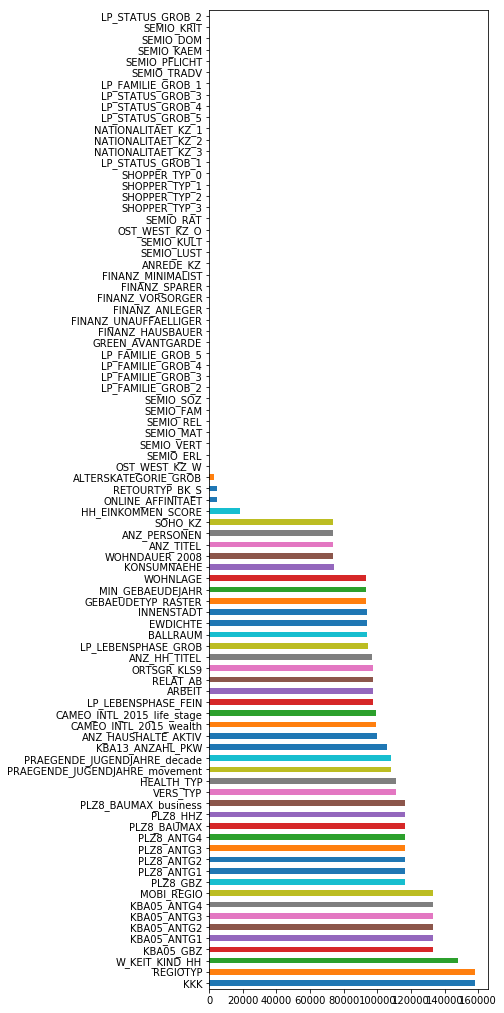

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

df_nan = data.isnull().sum().sort_values(ascending=False)
df_nan.plot(kind='barh', figsize=(5,18))

In [7]:
dataimputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
azdias_imputed = pd.DataFrame(dataimputer.fit_transform(data))
azdias_imputed.columns = data.columns
# check if there are any NaNs left
azdias_imputed.isnull().any().sum()

0

In [8]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed))
azdias_scaled.columns = azdias_imputed.columns
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,SHOPPER_TYP_1,SHOPPER_TYP_2,SHOPPER_TYP_3,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,PLZ8_BAUMAX_business
count,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,...,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05,8.912210e+05
mean,-2.077495e-15,4.604540e-15,-1.159741e-14,-8.662412e-16,1.585358e-14,1.034519e-14,-8.864517e-15,-5.733411e-15,-3.027970e-14,4.463153e-15,...,-6.254877e-15,6.078617e-15,-5.626719e-15,2.110577e-14,1.642791e-13,1.092077e-15,1.092077e-15,8.859711e-15,-3.973218e-15,2.202787e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.743339e+00,-1.045218e+00,-1.570358e+00,-1.243244e+00,-1.816084e+00,-1.329319e+00,-1.260597e+00,-1.533438e+00,-4.947009e-01,-1.644405e+00,...,-6.326754e-01,-5.508319e-01,-5.209155e-01,-4.829322e-01,-1.550999e+00,-2.181291e+00,-2.181291e+00,-1.674720e+00,-1.347861e+00,-5.870830e-01
25%,-7.516797e-01,-1.045218e+00,-8.133868e-01,-1.243244e+00,-3.033778e-01,-6.755539e-01,-5.879796e-01,-7.944745e-01,-4.947009e-01,-2.346007e-01,...,-6.326754e-01,-5.508319e-01,-5.209155e-01,-4.829322e-01,-1.550999e+00,-3.297446e-01,-3.297446e-01,-9.603583e-01,-1.347861e+00,-5.870830e-01
50%,2.399800e-01,9.567382e-01,-5.641562e-02,1.221788e-01,-3.033778e-01,-2.178896e-02,8.463740e-02,-5.551131e-02,-4.947009e-01,-2.346007e-01,...,-6.326754e-01,-5.508319e-01,-5.209155e-01,-4.829322e-01,6.447458e-01,-6.523799e-02,-6.523799e-02,4.683658e-01,8.057268e-02,-5.870830e-01
75%,1.231640e+00,9.567382e-01,7.005556e-01,8.048901e-01,1.209329e+00,1.285741e+00,7.572544e-01,6.834519e-01,-4.947009e-01,1.175204e+00,...,1.580589e+00,-5.508319e-01,-5.209155e-01,-4.829322e-01,6.447458e-01,1.257295e+00,1.257295e+00,1.182728e+00,7.947894e-01,1.284276e-01
max,1.231640e+00,9.567382e-01,1.457527e+00,1.487601e+00,1.209329e+00,1.285741e+00,1.429871e+00,1.422415e+00,2.021423e+00,1.175204e+00,...,1.580589e+00,1.815436e+00,1.919697e+00,2.070684e+00,6.447458e-01,1.521802e+00,1.521802e+00,1.182728e+00,1.509006e+00,2.274959e+00


### Discussion 2.1: Apply Feature Scaling

Several columns still had a large number of NaNs, partially this was by design, arising from the feature engineering section. To use as much data as possible for the upcoming steps, I decided to keep all features and fill the NaNs with the median to obtain at least meaningful labels for binary and categorical features. Describe() confirms that the final dataset now has a mean of 0 and a standard deviation of 1 so that the features contribute equally to the covariance matrix.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.

pca_population = PCA()
pca_population.fit(azdias_scaled);

Text(0.5,1,'Variance accounted for by each principal component')

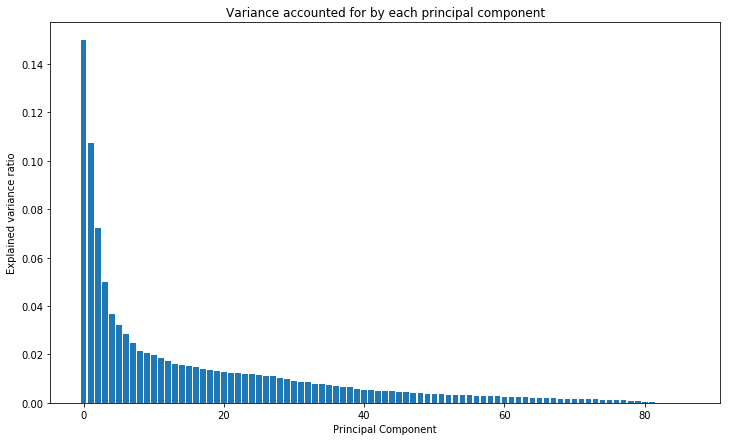

In [49]:
# Investigate the variance accounted for by each principal component.

fig = plt.figure(figsize=(12,7))
xaxis = range(len(pca_population.explained_variance_ratio_))
yaxis = pca_population.explained_variance_ratio_
plt.bar(xaxis, yaxis)
plt.xlabel("Principal Component")
plt.ylabel("Explained variance ratio")
plt.title("Variance accounted for by each principal component")

Text(0.5,1,'Cumulative variance accounted for by principal components')

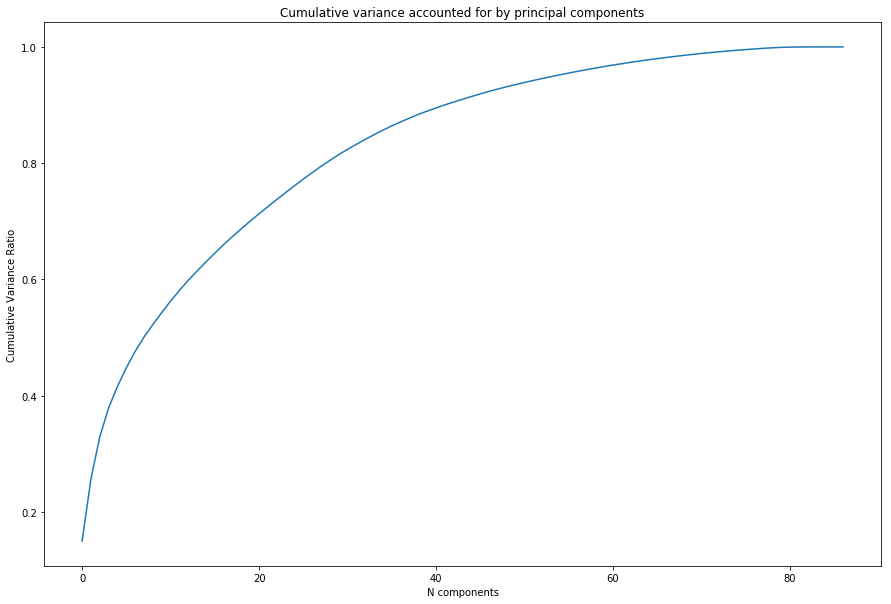

In [51]:
# using a scree plot to decide how many components to keep

ind = np.arange(len(pca_population.explained_variance_ratio_))
vals = np.cumsum(pca_population.explained_variance_ratio_)

fig = plt.figure(figsize=(15,10))
plt.plot(ind, vals)
plt.xlabel('N components')
plt.ylabel('Cumulative Variance Ratio')
plt.title("Cumulative variance accounted for by principal components")

In [9]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 40
pca_azdias = PCA(n_components)
pca_azdias.fit(azdias_scaled)
print(sum(pca_azdias.explained_variance_ratio_[0:n_components]))
azdias_reduced = pca_azdias.fit_transform(azdias_scaled)

0.8893949893837614


### Discussion 2.2: Perform Dimensionality Reduction

While I could not see an obvious elbow-point in the scree plot above, the incremental gain of explained variance was relatively small after about 40 components. Thus, I decided to retain 40 components in the dataset, which still contains about 89% of the whole variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

MOBI_REGIO               -0.2219
PLZ8_ANTG1               -0.2114
KBA05_ANTG1              -0.2031
KBA05_GBZ                -0.1982
FINANZ_MINIMALIST        -0.1904
PLZ8_GBZ                 -0.1577
KONSUMNAEHE              -0.1562
INNENSTADT               -0.1528
FINANZ_HAUSBAUER          0.1544
HH_EINKOMMEN_SCORE        0.1608
EWDICHTE                  0.1835
ORTSGR_KLS9               0.1853
CAMEO_INTL_2015_wealth    0.1869
LP_STATUS_GROB_1          0.1928
PLZ8_BAUMAX               0.1987
PLZ8_BAUMAX_business      0.1987
PLZ8_ANTG4                0.2064
PLZ8_ANTG3                0.2107
dtype: float64

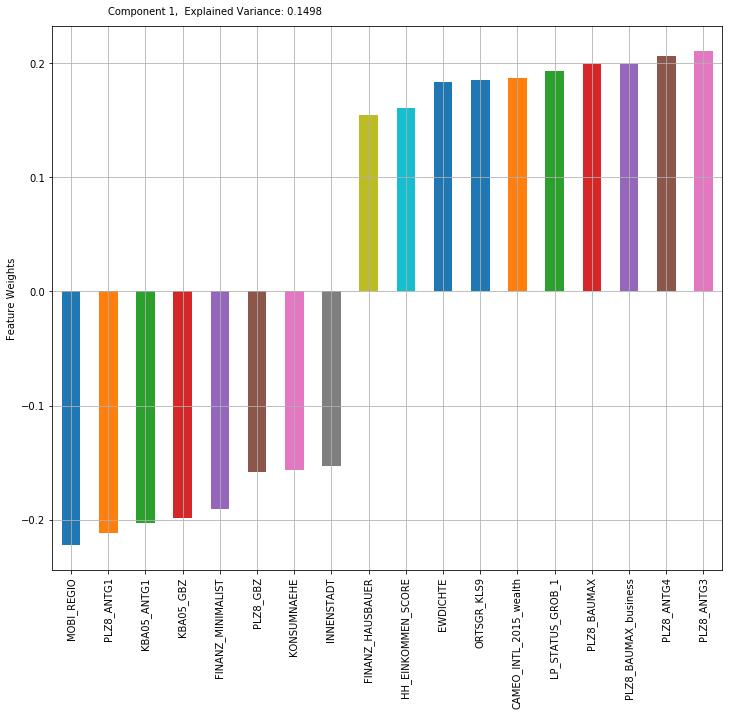

In [10]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca, component, threshold):
    '''
    Adapted from the udacity PCA lessons. 
    Creates a pandas Series of the feature weights for a single prinicpal component 
    and plots only the components with weight above a certain threshold value
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,component+2)]
    # PCA components
    components = pd.Series(data = np.round(pca.components_[component], 4), index = full_dataset.keys())
    
    useful_components = components[abs(components.values) > threshold].sort_values()
    
    # PCA explained variance
    ratio = pca.explained_variance_ratio_[component]
    variance_ratio = np.round(ratio, 4)

    # Create a bar plot visualization
    fig = plt.plot()

    # Plot the feature weights as a function of the components
    ax = useful_components.plot(fig = fig, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(useful_components.keys(), rotation=90)

    # Display the explained variance ratios
    ax.text(1, ax.get_ylim()[1] + 0.01, f"Component {component+1},  Explained Variance: {variance_ratio}")
    ax.yaxis.grid()
    ax.xaxis.grid()

    fig = plt.gcf()
    fig.set_size_inches(12, 10)
    # Return a concatenated DataFrame
    return useful_components


pca_results(azdias_scaled, pca_azdias, 0, threshold=0.15)

PRAEGENDE_JUGENDJAHRE_movement   -0.2646
PRAEGENDE_JUGENDJAHRE_decade     -0.2646
FINANZ_SPARER                    -0.2558
SEMIO_REL                        -0.2397
SEMIO_PFLICHT                    -0.2343
FINANZ_UNAUFFAELLIGER            -0.2328
FINANZ_ANLEGER                   -0.2247
SEMIO_TRADV                      -0.2209
SEMIO_RAT                        -0.1900
SEMIO_KULT                       -0.1707
SEMIO_FAM                        -0.1600
SEMIO_MAT                        -0.1570
ONLINE_AFFINITAET                -0.1518
RETOURTYP_BK_S                    0.1656
SEMIO_LUST                        0.1763
SEMIO_ERL                         0.2083
FINANZ_VORSORGER                  0.2463
ALTERSKATEGORIE_GROB              0.2602
dtype: float64

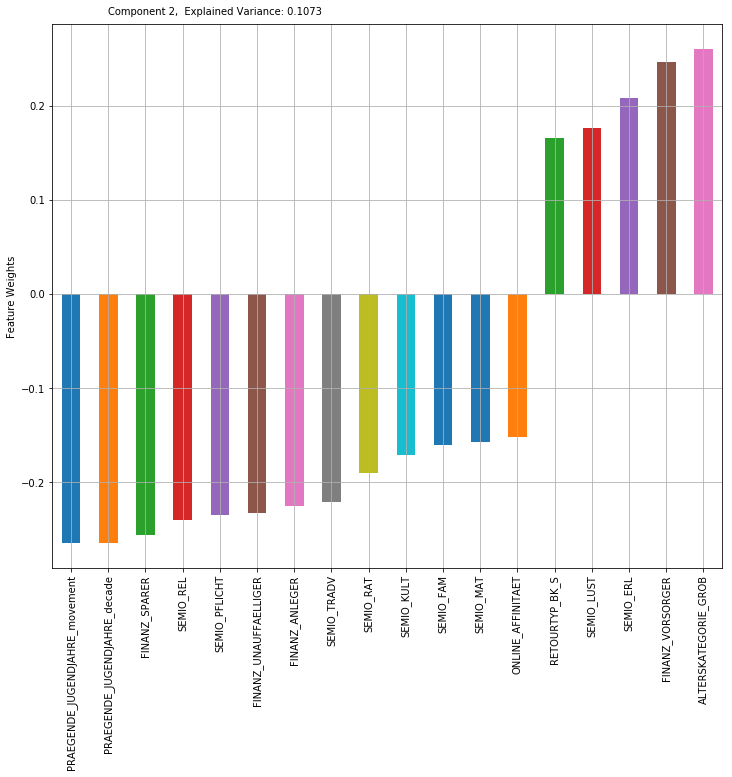

In [11]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_scaled, pca_azdias, 1, threshold=0.15)

SEMIO_KAEM       -0.3502
ANREDE_KZ        -0.3433
SEMIO_DOM        -0.3225
SEMIO_KRIT       -0.3067
SEMIO_ERL        -0.1809
FINANZ_ANLEGER   -0.1644
SEMIO_RAT        -0.1574
SEMIO_FAM         0.2258
SEMIO_KULT        0.2827
SEMIO_SOZ         0.2887
SEMIO_VERT        0.3460
dtype: float64

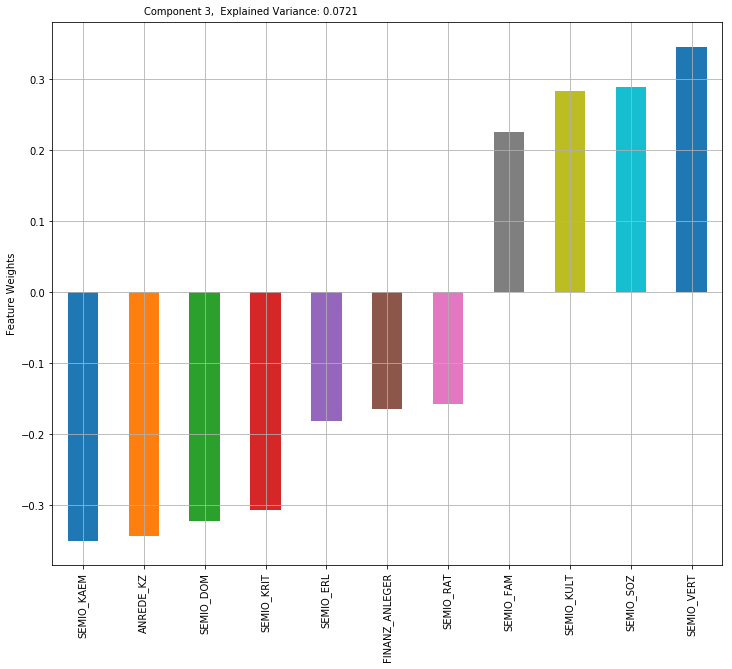

In [12]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_scaled, pca_azdias, 2, threshold=0.15)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

In the following I pick several of the strongest or most readily interpretable features for each principal component.

**1st Principal Component:**

The component is strongly correlated with higher movement patterns in the region (the weight is negative, but MOBI_REGIO is encoded with smaller values representing high movement and vice versa)
The component has positive weights for many related features that represent very large family homes (PLZ8_ANTG3, PLZ8_ANTG4) and business buildings (here we find our engineered feature PLZ8_BAUMAX_business), whereas components for small family homes (PLZ8_ANTG1, KBA05_ANTG1) have negative weights. This makes intuitively sense, in that the small homes are probably homeowners that which show less mobility in contrast to the rented apartments or business spaces.

**2nd Principal Component:**

Here we find strong negative weights for our two constructed features PRAEGENDE_JUGENDJAHRE_movement and PRAEGENDE_JUGENDJAHRE_decade. We can now easily interpret that these people tended towards the mainstream as opposed to the avantgarde movements and did so in the earlier decades of the 20th century. This is also confirmed by the positive weight on ALTERSKATEGORIE_GROB which encodes older ages for larger values.

**3rd Principal Component:**

This component has several large weights. The strongest negative weight for SEMIO_KAEM represents a high affinity towards a combative attitude. This may be explained by ANREDE_KZ: a negative weight represents male gender. Another stereotype seems to be confirmed: The males appear to have a lower affinity towards being "dreamful" as represented by SEMIO_VERT.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [14]:
# Over a number of different cluster counts...
models = []
for i in range(1, 15):
    models.append(KMeans(n_clusters=i))

    # run k-means clustering on the data and...
for model in models:
    model.fit(azdias_reduced)   
    
    # compute the average within-cluster distances.
scores = []
for model in models:
    scores.append(np.abs(model.score(azdias_reduced)))    
    

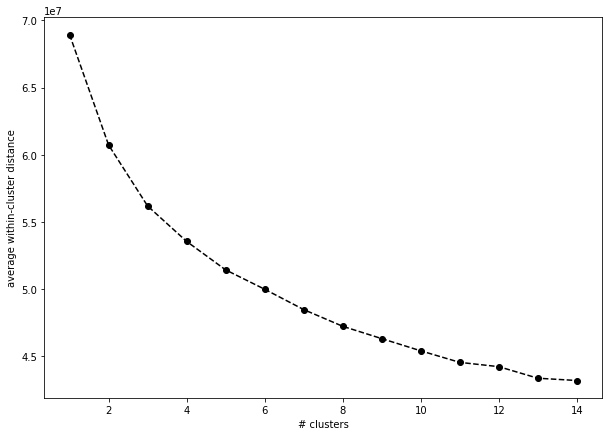

In [15]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(10, 7))
xaxis=range(1, 15)
plt.plot(xaxis, scores, linestyle='--', marker='o', color='k')
plt.xlabel('# clusters')
plt.ylabel('average within-cluster distance')
plt.show()

In [16]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_azdias = KMeans(n_clusters = 10)
azdias_clusters = kmeans_azdias.fit_predict(azdias_reduced)

### Discussion 3.1: Apply Clustering to General Population

Although I could not see an obvious elbow-point in above plot, I decided to pick 10 clusters as the average within-cluster distance did not strongly decrease from this number onwards. Further, a recommended blog post mentioned that it is rarely useful to have more than ten segments (https://medium.com/tools-for-entrepreneurs/segmentation-the-basics-for-understanding-your-customers-f835a98c8e1d)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [17]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [18]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

data_customers = clean_data(customers, feat_info)

C:\Users\felix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


dropping CJT_GESAMTTYP


C:\Users\felix\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


dropping FINANZTYP
dropping GFK_URLAUBERTYP
dropping LP_FAMILIE_FEIN
dropping LP_STATUS_FEIN
dropping ZABEOTYP
dropping GEBAEUDETYP
dropping CAMEO_DEUG_2015
dropping CAMEO_DEU_2015


C:\Users\felix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LP_FAMILIE_GROB re-encoded
LP_STATUS_GROB re-encoded
NATIONALITAET_KZ re-encoded
SHOPPER_TYP re-encoded
OST_WEST_KZ re-encoded


In [19]:
# Impute remaining NaNs
customers_imputed = pd.DataFrame(dataimputer.transform(data_customers))
customers_imputed.columns = data_customers.columns

# Apply feature scaling
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed))
customers_scaled.columns = customers_imputed.columns

# Apply PCA dimensionality reduction
customers_reduced = pca_azdias.transform(customers_scaled)

# Obtain clusters
customer_clusters = kmeans_azdias.predict(customers_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [20]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

clusters = 10
n_population = []
n_customer = []
for i in range(clusters):
    n_population.append(np.argwhere(azdias_clusters==i).shape[0]/azdias_clusters.shape[0])
    n_customer.append(np.argwhere(customer_clusters==i).shape[0]/customer_clusters.shape[0])

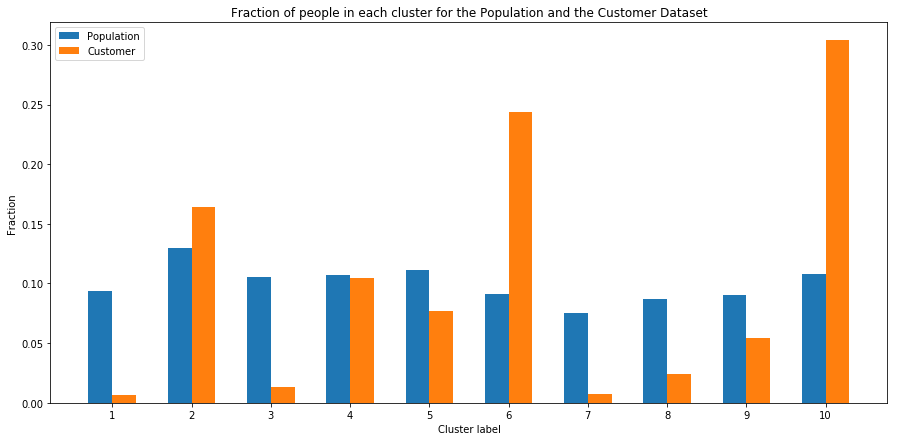

In [31]:
label_counts = pd.DataFrame({'Population Data': n_population})
label_counts['Customer Data'] = pd.Series(n_customer)
label_counts['Clusters'] = pd.Series(list(range(clusters)))

customer_props = label_counts['Customer Data']
population_props = label_counts['Population Data']

ind = np.arange(clusters)+1 
width=0.3
plt.figure(figsize=(15,7))
plt.bar(ind, population_props, width, label='Population')
plt.bar(ind + width, customer_props, width,
    label='Customer')

plt.ylabel('Fraction')
plt.xlabel('Cluster label')
plt.xticks(ind + width / 2, range(1,clusters+1))
plt.legend(loc='best')
plt.title('Fraction of people in each cluster for the Population and the Customer Dataset')
plt.show()

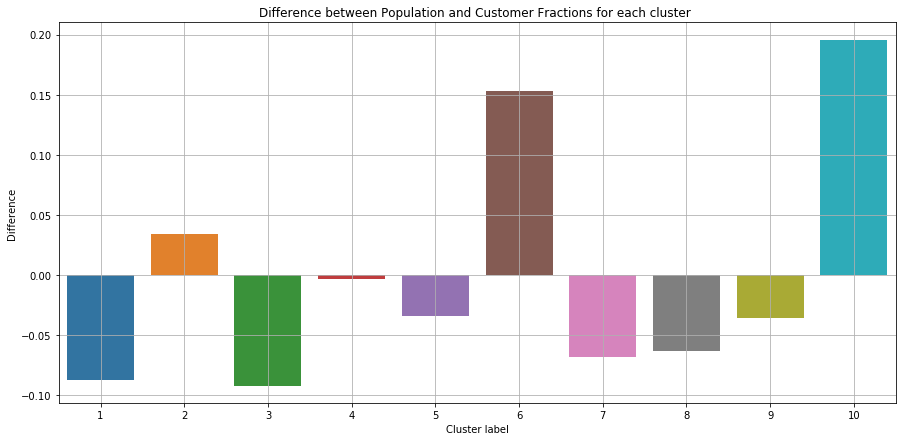

In [32]:
# In the following positive bars indicated that customers are overrepresented
# compared to the population, while negative pars indicate that customers are underrepresented
# within a given cluster.
difference = pd.DataFrame({'Cluster label':ind, 'Difference':label_counts['Customer Data']-label_counts['Population Data']})

plt.figure(figsize=(15,7))
sns.barplot(x='Cluster label', y='Difference', data=difference)
plt.title('Difference between Population and Customer Fractions for each cluster ')
plt.ylabel('Difference')
plt.grid(True)

In [27]:
def compare_pca_values(customers_reduced, customer_clusters, population_reduced, population_clusters, cluster):
    # obtain df with the pca values filtered by a given cluster
    pca_values_customers = pd.DataFrame(customers_reduced[customer_clusters==cluster,:])
    pca_values_population = pd.DataFrame(population_reduced[population_clusters==cluster,:])
    
    # Consider only the average values for the first 3 principal components
    customers_mean = pca_values_customers.mean()[0:3]
    population_mean = pca_values_population.mean()[0:3]

    # Plot comparison between Customer and Population dataset for this cluster and components
    ind = np.arange(0,3) 
    width=0.3

    plt.figure(figsize=(10,7))
    plt.bar(customers_mean.index, customers_mean, width, label='Customers')
    plt.bar(population_mean.index + width, population_mean, width,
        label='Population')

    plt.ylabel(f'PC Value within Cluster {cluster}')
    plt.xlabel('Principal Component')
    plt.xticks(ind + width / 2, range(1,4))
    plt.legend(loc='best')


Below I plot the contributions of each PCA to a given cluster for customers and population separately. Though I am not sure how to interpret the slight differences in the amplitudes between the two groups (presumably the methods that were fit to the population data contained a certain noise that made the transformation of the customer dataset less than perfect, the smaller sample size of the customer dataset could have affected some of the features, etc.), they both show generally the same trend.

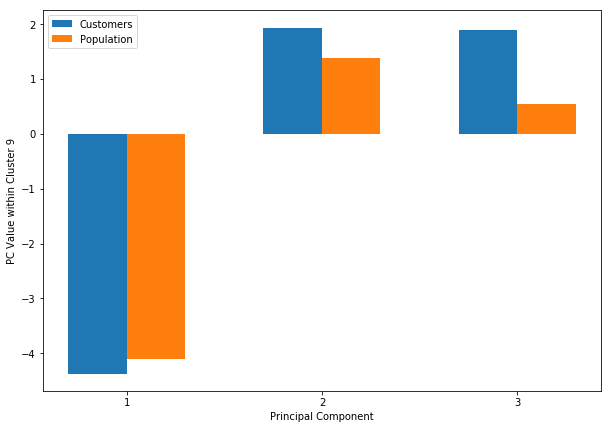

In [28]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# People in cluster 9
compare_pca_values(customers_reduced, customer_clusters, azdias_reduced, azdias_clusters, 9)

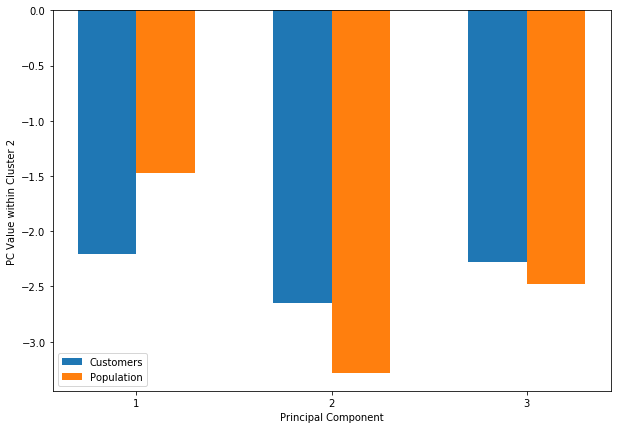

In [29]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# People in cluster 2
compare_pca_values(customers_reduced, customer_clusters, azdias_reduced, azdias_clusters, 2)

### Discussion 3.3: Compare Customer Data to Demographics Data

Conrasting the two clusters where customers are most over- or under-represented, and considering only the first three principal components, which we interpreted in step 2.3, I would draw the following conclusions:
The customers tend to be older (and followed the "avantgarde" movements) as shown by component 2, and they tend to be male, as shown by component 3. In both cases this is consistent in the clusters, as people in the underrepresented cluster have the opposite sign for these components than those in the overrepresented cluster.
No conclusive statement can be made about the first principal component, as both the under- and over-represented clusters tend to contain people from regions with less mobility and smaller family homes. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.